In [2]:
# Step 1: Install required libraries (only run once)
!pip install -q transformers
!pip install -q scikit-learn

In [3]:
# Step 2: Import libraries
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
# Step 3: Upload your CSV file
from google.colab import files
uploaded = files.upload()

Saving NikeProductDescriptions.csv to NikeProductDescriptions (1).csv


In [5]:
# Step 4: Load and filter the data
df = pd.read_csv(next(iter(uploaded)))

# Define allowed subtitles
keywords = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]

# Filter relevant subtitles
df_filtered = df[df['Subtitle'].isin(keywords) | df['Subtitle'].str.contains("Shorts", case=False)].copy()
df_filtered['Subtitle'] = df_filtered['Subtitle'].apply(lambda x: "Shorts" if "Shorts" in x else x)


In [6]:
# Step 5: Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
# Step 6: Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

In [8]:
# Step 7: Generate embeddings
embeddings = []
for desc in tqdm(df_filtered['Product Description']):
    embeddings.append(get_bert_embedding(desc))

100%|██████████| 155/155 [01:32<00:00,  1.67it/s]


In [9]:
# Step 8: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

In [10]:
# Step 9: Create a DataFrame for plotting
plot_df = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
plot_df['Category'] = df_filtered['Subtitle'].values

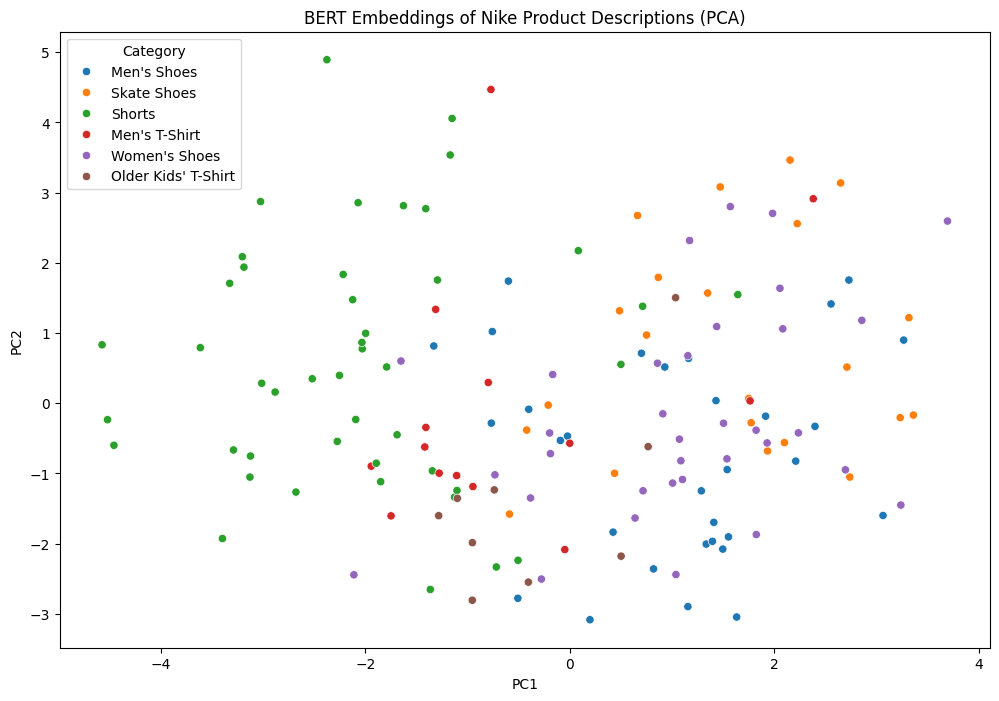

In [11]:
# Step 10: Plot using seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Category', palette='tab10')
plt.title('BERT Embeddings of Nike Product Descriptions (PCA)')
plt.show()